In [ ]:
################################################################
# optional installs

#!pip install tensorflow==1.14.0 --ignore-installed
#!pip install keras==2.2.4
#!pip install opencv-python
#!pip install pandas
#!pip install tqdm
################################################################

In [ ]:
%tensorflow_version 1.x

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

In [ ]:
################################################################
# optional

import warnings

from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"
################################################################

In [ ]:
################################################################
# imports
import os
from os.path import exists


import numpy as nump
import pandas as pd
from collections import defaultdict
from glob import glob
import h5py
from random import choice, sample
import cv2
from tqdm import tqdm
import pickle

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, \
    Reshape, Flatten, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras import backend as K
from keras.models import load_model
from keras import regularizers
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt

################################################################

In [ ]:
################################################################
# Fetch all images, and split into training and validation images

training_dataset = 'Documents/AI/train/'
validation_dataset = 'F08'
dataset = glob(training_dataset + '*/*/*.jpg')
dataset = [img.replace("\\", "/") for img in dataset]
training_images = [img for img in dataset if validation_dataset not in img]
validation_images = [img for img in dataset if validation_dataset in img]

print("Dataset Found") if exists(training_dataset) else print("Dataset Not Found. Please check path")

print("Total images", len(dataset))
print("Number of training images", len(training_images))
print("Number of validation images", len(validation_images))
################################################################

Dataset Found
Total images 12379
Number of training images 11051
Number of validation images 1328


In [ ]:
################################################################
# Extracting people from images
training_people = defaultdict(list)
for img in training_images:
    training_people[img.split('/')[-3] + '/' + img.split('/')[-2]].append(img)

validation_people = defaultdict(list)
for img in validation_images:
    validation_people[img.split('/')[-3] + '/' + img.split('/')[-2]].append(img)

print("Total people in training dataset", len(training_people))
print("Total people in training dataset", len(validation_people))
################################################################

Total people in training dataset 2051
Total people in training dataset 265


In [ ]:
################################################################
# Reading the csv and forming relationships
train_pair = 'Documents/AI/train_relationships.csv'
print("CSV Found") if exists(train_pair) else print("CSV Not Found Please check path")
csv = pd.read_csv(train_pair)
csv = list(zip(csv.p1.values, csv.p2.values))
updatedDataset = [img.split('/')[-3] + '/' + img.split('/')[-2] for img in dataset]
csv = [row for row in csv if row[0] in updatedDataset and row[1] in updatedDataset]
################################################################

CSV Found


In [ ]:
################################################################
training = [row for row in csv if validation_dataset not in row[0]]
print(len(training))
validation = [row for row in csv if validation_dataset in row[0]]
print(len(validation))

################################################################

2988
374


In [ ]:
################################################################
# Function to read image
def get_img(path):
    image = cv2.imread(path)
    image = nump.array(image).astype(nump.float)
    return preprocess_input(image, version=2)


################################################################

In [ ]:
################################################################
# Generator
def gen(tuples, people, batch_size=16):
    people_list = list(people.keys())

    while True:
        batch = sample(tuples, batch_size // 2)
        labels = [1] * len(batch)
        while len(batch) < batch_size:
            person1 = choice(people_list)
            person2 = choice(people_list)

            if person1 != person2 and (person1, person2) not in tuples and (person2, person1) not in tuples:
                batch.append((person1, person2))
                labels.append(0)
        yield from gen_util(batch, labels, people)


################################################################

In [ ]:
################################################################
def gen_util(batch, labels, people):
    for x in batch:
        if not len(people[x[0]]):
            print(x[0])
    X1 = [choice(people[x[0]]) for x in batch]
    X1 = nump.array([get_img(x) for x in X1])
    X2 = [choice(people[x[1]]) for x in batch]
    X2 = nump.array([get_img(x) for x in X2])
    yield [X1, X2], labels


################################################################

In [ ]:
################################################################

# Model architecture
def get_model2():
    input1 = Input(shape=(224, 224, 3))
    input2 = Input(shape=(224, 224, 3))

    base_mdl = VGGFace(model='resnet50', include_top=False)

    x = layers(base_mdl, input1, input2)
    out = Dense(1, activation='sigmoid')(x)
    mdl = Model([input1, input2], out)
    mdl.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=Adam(0.00001))
    mdl.summary()

    return mdl


################################################################

In [ ]:
################################################################
# Layers for the model
def layers2(base_mdl, input1, input2):
    x1 = base_mdl(input1)
    x2 = base_mdl(input2)
    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x5 = Multiply()([x1, x2])
    last = Concatenate(axis=-1)([x3, x4, x5])
    last = Dense(100, activation='relu')(last)
    last = Dropout(0.01)(last)
    return last


################################################################

In [ ]:
################################################################
# Model architecture 2
def get_model_3():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_mdl = VGGFace(model='resnet50', include_top=False)

    x = layers2(base_mdl, input_1, input_2)
    out = Dense(1, activation="sigmoid")(x)
    mdl = Model([input_1, input_2], out)
    mdl.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=Adam(0.00001))
    mdl.summary()

    return mdl


################################################################

In [ ]:
################################################################
# Layers for the model 2
def layers3(base_mdl, input_1, input_2):
    x1 = base_mdl(input_1)
    x2 = base_mdl(input_2)
    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x5 = Multiply()([x1, x2])
    last = Concatenate(axis=-1)([x3, x4, x5])
    last = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(last)
    last = BatchNormalization()(last)
    last = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(last)
    last = Dropout(0.01)(last)
    last = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(last)
    last = BatchNormalization()(last)
    last = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(last)
    last = Dropout(0.01)(last)
    last = Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01))(last)
    return last


################################################################

In [ ]:
################################################################
def get_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers:
        x.trainable = False

    x = layers3(base_model, input_1, input_2)
    out = Dense(1, activation='sigmoid')(x)
    mdl = Model([input_1, input_2], out)
    mdl.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=Adam(0.00001))
    mdl.summary()

    return mdl


################################################################

In [ ]:
################################################################
def layers(base_model, input_1, input_2):
    x1 = base_model(input_1)
    x2 = base_model(input_2)
    x = Concatenate()([x1, x2])
    x = Flatten()(x)
    x = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.01)(x)
    return x


################################################################

In [ ]:
################################################################
# start
path_split = '/'
if os.name == 'nt':
    path_split = '\\'

model_name = 'vggface_model.h5'

pkl_name = 'network.pkl'

save_path = f'Documents{path_split}AI{path_split}{model_name}'

best_model = ModelCheckpoint(save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=20, verbose=1)
checkpoints = [best_model, lr_reducer]

# model = get_model()
# network = model.fit_generator(gen(training, training_people, batch_size=16),
#                               validation_data=gen(validation, validation_people, batch_size=16),
#                               epochs=50, verbose=1, workers=1, callbacks=checkpoints, steps_per_epoch=100,
#                               validation_steps=100)
# model = get_model_2()
# network = model2.fit_generator(gen(training, training_people, batch_size=16),
#                                                   validation_data=gen(validation, validation_people, batch_size=16),
#                                                   epochs=50, verbose=1, workers=1, callbacks=checkpoints,
#                                                   steps_per_epoch=100,
#                                                   validation_steps=100)

model = get_model_3()
network = model2.fit_generator(gen(training, training_people, batch_size=16),
                                                  validation_data=gen(validation, validation_people, batch_size=16),
                                                  epochs=100, verbose=1, workers=1, callbacks=checkpoints,
                                                  steps_per_epoch=100,
                                                  validation_steps=100)
################################################################









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]           

In [ ]:
################################################################

# save history
with open(f'Documents{path_split}AI{path_split}{pkl_name}', 'wb') as f:
    pickle.dump(network, f)

model.save(f'Documents{path_split}AI{path_split}{model_name}')
################################################################

In [ ]:
################################################################

# DONE WITH TRAINING

################################################################

In [ ]:
################################################################

# TESTING PHASE

################################################################

In [ ]:
################################################################
file = open(f'Documents{path_split}AI{path_split}{pkl_name}', 'rb')
network = pickle.load(file)
file.close()

model = load_model(f'Documents{path_split}AI{path_split}{model_name}')

sampleCSV = pd.read_csv(f'Documents{path_split}AI{path_split}sample_submission.csv', header=0)


# generates test data in batches
def get_batches_test(test, size=32):
    return (test[i:i + size] for i in range(0, len(test), size))


################################################################

In [ ]:
################################################################
results = []
test_folder = f'Documents{path_split}AI{path_split}test{path_split}'

for eachBatch in tqdm(get_batches_test(sampleCSV.img_pair.values)):
    person1 = [row.split("-")[0] for row in eachBatch]
    person1 = nump.array([get_img(test_folder + x) for x in person1])

    person2 = [x.split("-")[1] for x in eachBatch]
    person2 = nump.array([get_img(test_folder + x) for x in person2])

    curr_result = model.predict([person1, person2]).ravel().tolist()
    results += curr_result

sampleCSV['is_related'] = results
################################################################

In [ ]:
################################################################
# output csv
sampleCSV.to_csv(f'Documents{path_split}AI{path_split}results.csv', index=False)
################################################################

In [ ]:
################################################################
def plot_acc_graph():
    train_accuracy = network.history['acc'][:50]
    validation_accuracy = network.history['val_acc'][:50]
    acc_epochs = range(len(train_accuracy))
    plt.plot(acc_epochs, train_accuracy, 'b', label='Training accuracy')
    plt.plot(acc_epochs, validation_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy - multi dense')
    plt.legend()
    plt.figure()


################################################################

In [ ]:
################################################################
def plot_loss_graph():
    train_loss = network.history['loss'][:50]
    validation_loss = network.history['val_loss'][:50]
    loss_epochs = range(len(train_loss))
    plt.plot(loss_epochs, train_loss, 'b', label='Training loss')
    plt.plot(loss_epochs, validation_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss - multi dense')
    plt.legend()
    plt.figure()


################################################################

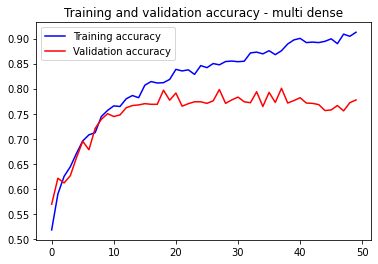

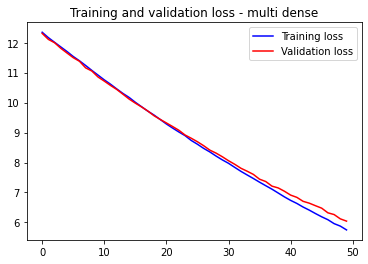

<Figure size 432x288 with 0 Axes>

In [ ]:
################################################################

# Generating Visualizations
plot_acc_graph()
plot_loss_graph()

################################################################